In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

# Read 256x256 images in directory

In [3]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=0,
                     width_shift_range=0,
                     height_shift_range=0,
                     zoom_range=0)
val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_data_gen_args)

In [12]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_size=5
train_image_generator = train_image_datagen.flow_from_directory(
    'data/train/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'data/train/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
train_generator = zip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'data/val/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'data/val/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_generator = zip(val_image_generator, val_mask_generator)
# image_datagen.fit(images, augment=True, seed=seed)
# mask_datagen.fit(masks, augment=True, seed=seed)

Found 107 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


In [5]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [6]:
try: 
    model
except:
    model = models.load_model('weights.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [13]:
test_imgs = val_image_generator.next()
test_masks = val_mask_generator.next()
# Let's visualize some of the outputs 
predictions = model.predict_on_batch(test_imgs)

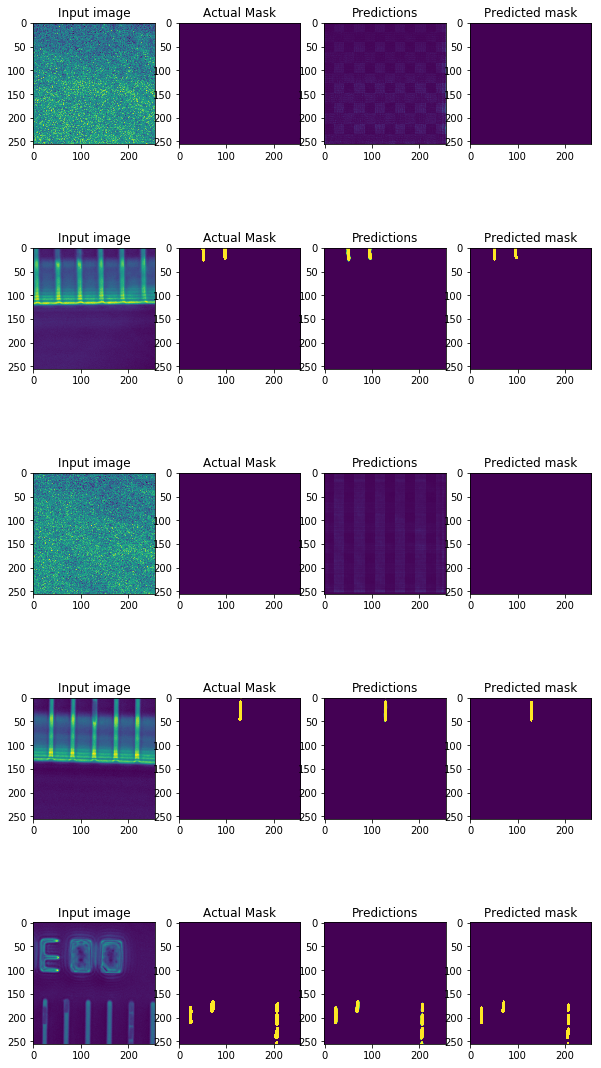

In [14]:
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
    img = test_imgs[i,:,:,0]
    label = test_masks[i,:,:,0]
    predicted_label = predictions[i,:,:,0]

    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(label)
    plt.title("Actual Mask")
    
    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(predicted_label)
    plt.title("Predictions")
    
    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(predicted_label>0.99)
    plt.title("Predicted mask")
    
plt.show()